In [67]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import tensorflow_addons as tfa


In [68]:
df = pd.read_csv('../data/pre-processed.csv')
df = df.drop(columns=['index'])
df.isnull().any()

label                False
preprocessed_news    False
dtype: bool

In [69]:
df['label'] = df.apply(lambda row: 1 if row.label == 'fake' else 0, axis=1)
X = df.drop(['label'], axis = 1)
Y = df['label']

In [70]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 5, stratify=Y)

X_train = X_train['preprocessed_news'].apply(lambda x: x.lower())
X_test = X_test['preprocessed_news'].apply(lambda x: x.lower())

train_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')
train_tokenizer.fit_on_texts(X_train.values)
train_word_index = train_tokenizer.word_index


In [71]:
train_sequences = train_tokenizer.texts_to_sequences(X_train)
vocab_length = len(train_word_index) + 1
test_sequences = train_tokenizer.texts_to_sequences(X_test)

print(f'Vocab length {vocab_length}, Train sequences {len(train_sequences)}, Test sequences {len(test_sequences)} ')

Vocab length 72906, Train sequences 5760, Test sequences 1440 


In [72]:
maxlen=40
train_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, padding='post', maxlen=maxlen, truncating='post')
test_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, padding='post', maxlen=maxlen, truncating='post')

In [173]:
embedding_dim = 6
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, embedding_dim, input_length=maxlen),
    tf.keras.layers.GRU(60, activation='tanh', return_sequences=True),
    tf.keras.layers.LSTM(30, return_sequences=True),
    tf.keras.layers.SimpleRNN(3, activation='tanh', return_sequences=True),
    tf.keras.layers.SimpleRNN(3, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 6)             437436    
                                                                 
 gru (GRU)                   (None, 40, 60)            12240     
                                                                 
 lstm (LSTM)                 (None, 40, 30)            10920     
                                                                 
 simple_rnn (SimpleRNN)      (None, 40, 3)             102       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 3)                 21        
                                                                 
 dropout (Dropout)           (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 24)                9

In [174]:

history = model.fit(train_padded_seqeunces, y_train, epochs=10, batch_size=100, validation_data=[test_padded_seqeunces, y_test])


Epoch 1/10
58/58 [==============================] - 9s 86ms/step - loss: 0.6937 - accuracy: 0.4877 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/10
58/58 [==============================] - 4s 73ms/step - loss: 0.6923 - accuracy: 0.5200 - val_loss: 0.6890 - val_accuracy: 0.5417
Epoch 3/10
58/58 [==============================] - 4s 74ms/step - loss: 0.5754 - accuracy: 0.7776 - val_loss: 0.4919 - val_accuracy: 0.8062
Epoch 4/10
58/58 [==============================] - 4s 72ms/step - loss: 0.2669 - accuracy: 0.9293 - val_loss: 0.4802 - val_accuracy: 0.8146
Epoch 5/10
58/58 [==============================] - 4s 73ms/step - loss: 0.1485 - accuracy: 0.9620 - val_loss: 0.4665 - val_accuracy: 0.8382
Epoch 6/10
58/58 [==============================] - 4s 72ms/step - loss: 0.0812 - accuracy: 0.9792 - val_loss: 0.4917 - val_accuracy: 0.8493
Epoch 7/10
58/58 [==============================] - 4s 73ms/step - loss: 0.0667 - accuracy: 0.9847 - val_loss: 0.7427 - val_accuracy: 0.7951
Epoch 8/10
58

45/45 [==============================] - 1s 12ms/step


<Axes: >

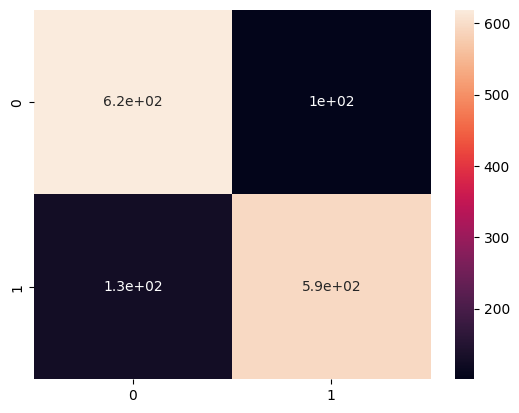

In [175]:
from sklearn.metrics import confusion_matrix
y_train_pred = model.predict(test_padded_seqeunces)
y_train_pred = (y_train_pred > 0.75)
cm = confusion_matrix(y_test, y_train_pred)
sns.heatmap(cm, annot=True)

# Visualize the results:

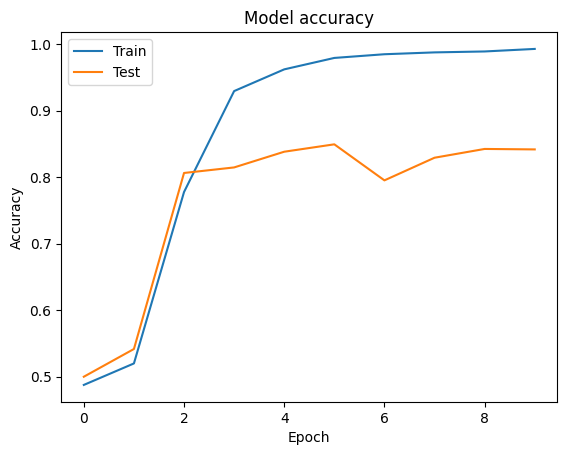

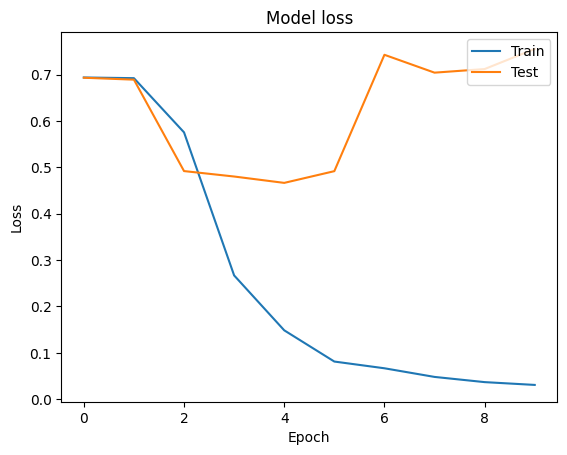

In [176]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Salva modelo